In [1]:
from tensorflow.keras.models import load_model,model_from_json
import matplotlib.pyplot as plt
import numpy as np
from Utils.Data_Loader import get_train_test_data
from tensorflow.keras.optimizers import Adam
from Utils.plotter import plotter
from Utils.losses import *
from Utils.u_net import u_net
from Utils.Data_Augmentation import*
from sklearn.model_selection import KFold
import sys
import math


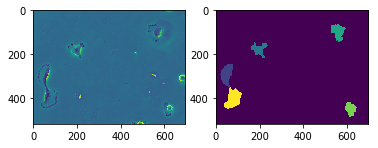

In [6]:
from skimage.io import imread
import matplotlib.pyplot as plt
img = imread('PhC-C2DH-U373/01/t010.tif',as_grey=True)
ground_truth= imread('PhC-C2DH-U373/01_GT/SEG/man_seg010.tif',as_grey=True)

plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(ground_truth)


In [2]:
#Data parameters
img_h = 128
img_w = 128
img_ch = 1
fold1 = '01'
fold2 = '01_GT/SEG'
data_path = 'PhC-C2DH-U373'
train_img, train_mask, weight_maps = get_train_test_data(fold1, fold2, data_path, img_h, img_w)  

/usr/local/lib/python3.5/dist-packages/skimage/io/_io.py:48: UserWarning: `as_grey` has been deprecated in favor of `as_gray`
  warn('`as_grey` has been deprecated in favor of `as_gray`')


Reading: 0/34  of train images
Reading: 0/34  of train images


## Loading models that didn't use weight maps

In [38]:
# Model reconstruction from JSON file

with open('Models/FR-Fa-GE/FR-Fa-GE_architecture_fold2_old.json', 'r') as f:
    model = model_from_json(f.read())

# Load weights into the new model
model.load_weights('Models/FR-Fa-GE/FR-Fa-GE_weights_fold2_old.h5')

In [39]:
predictions = model.predict(train_img)

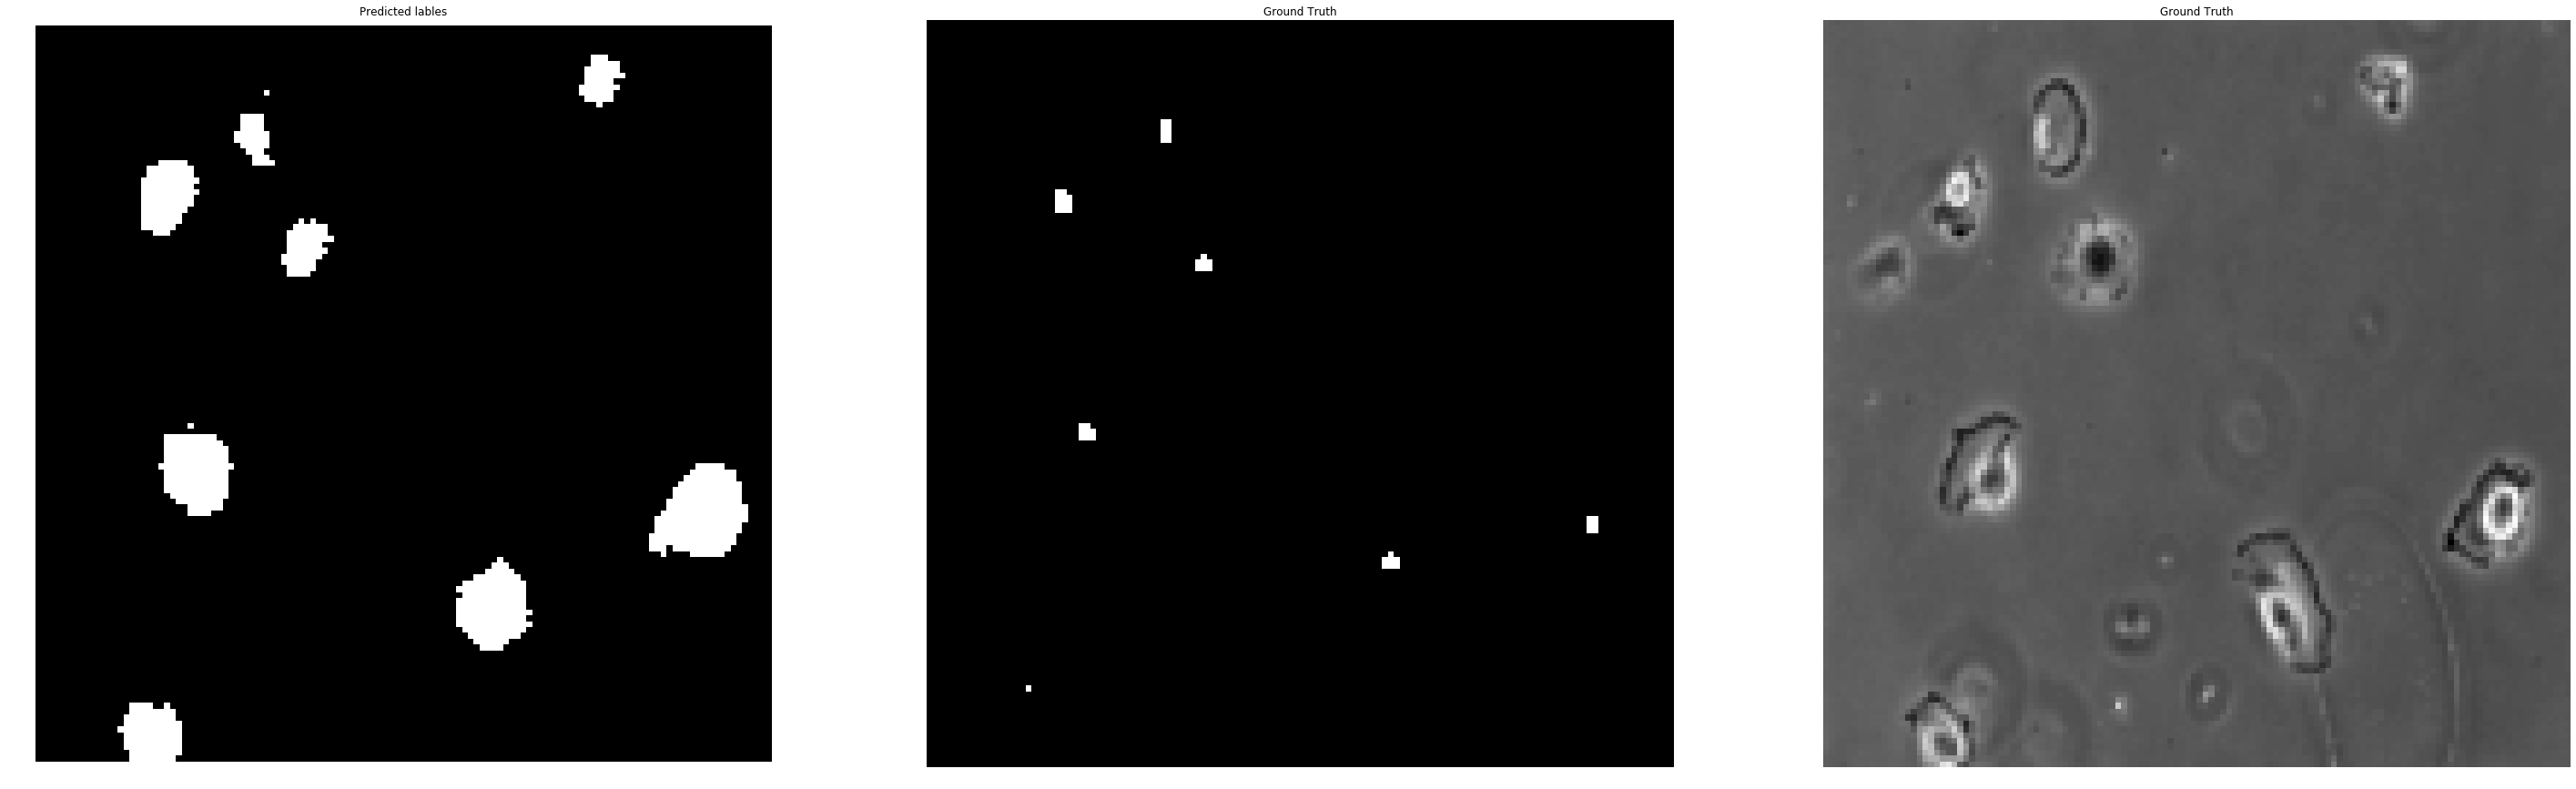

In [40]:
fig_acc = plt.figure(figsize=(50,50))

# add a polar subplot
plt.subplot(131)
plt.title("Predicted lables")
predictions[predictions>0.0015]=1
plt.imshow(predictions[14,:,:,0], cmap = "gray")
plt.axis('off')


plt.subplot(132)
plt.title("Ground Truth")
plt.imshow(train_mask[14,:,:,0], cmap = "gray")

plt.axis('off')


plt.subplot(133)
plt.title("Ground Truth")
plt.imshow(train_img[14,:,:,0], cmap = "gray")
plt.colorbar
plt.axis('off')
plt.show()

## Load models that usesd weight maps

In [3]:
# Model parameters
base = 32
batch_size = 8
LR = 0.00001
SDRate = 0.5
batch_normalization = True
spatial_dropout = True
epochs = 150
final_neurons= 1 #binary classification
final_afun = "sigmoid" #activation function
weight_strength = 1.


In [4]:
# Build the model

from Utils.u_net_LSTM import u_net_lstm
predictions =[]
models = ["U_Net/U_Net_weights_BN_False_DA_True_BW_True.h5"]

for modeli in models:
    if "Weigthed" in modeli:
        print("true")
        weights = True
    if "FR-Fa-GE" in modeli:
        weights = True
    else:
        print("false")
        weights = False
    
    if "LSTM" in modeli:
        if weights:
            model, input_weights = u_net_lstm(base, img_w, img_h, img_ch, batch_normalization, SDRate, spatial_dropout, final_neurons,"sigmoid",weights)
        else:
            model = u_net_lstm(base, img_w, img_h, img_ch, batch_normalization, SDRate, spatial_dropout, final_neurons,"sigmoid",weights)
       
    else:
        if weights:
            model, input_weights = u_net(base, img_w, img_h, img_ch, batch_normalization, SDRate, spatial_dropout, final_neurons,"sigmoid",weights)
        else:
            model = u_net(base, img_w, img_h, img_ch, batch_normalization, SDRate, spatial_dropout, final_neurons,"sigmoid",weights)
       
    # Load weights into the new model
    print("loading weigths")
    model.load_weights('Models/'+modeli)

    #Compile the model with weighted cross-entropy loss and metric as jaccard_distance
    model.compile(optimizer = Adam(lr=LR), loss = 'binary_crossentropy', metrics =[jaccard_loss])

    predictions.append(model.predict([train_img,weight_maps]))
    



false
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v2 (BatchNo (None, 128, 128, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 32) 0           batch_normalization_v2[0][0]     
________________________________________________________________________________________

In [43]:
# Make predictions with test data
#predictions = model.predict([train_img,weight_maps])
len(predictions)

4

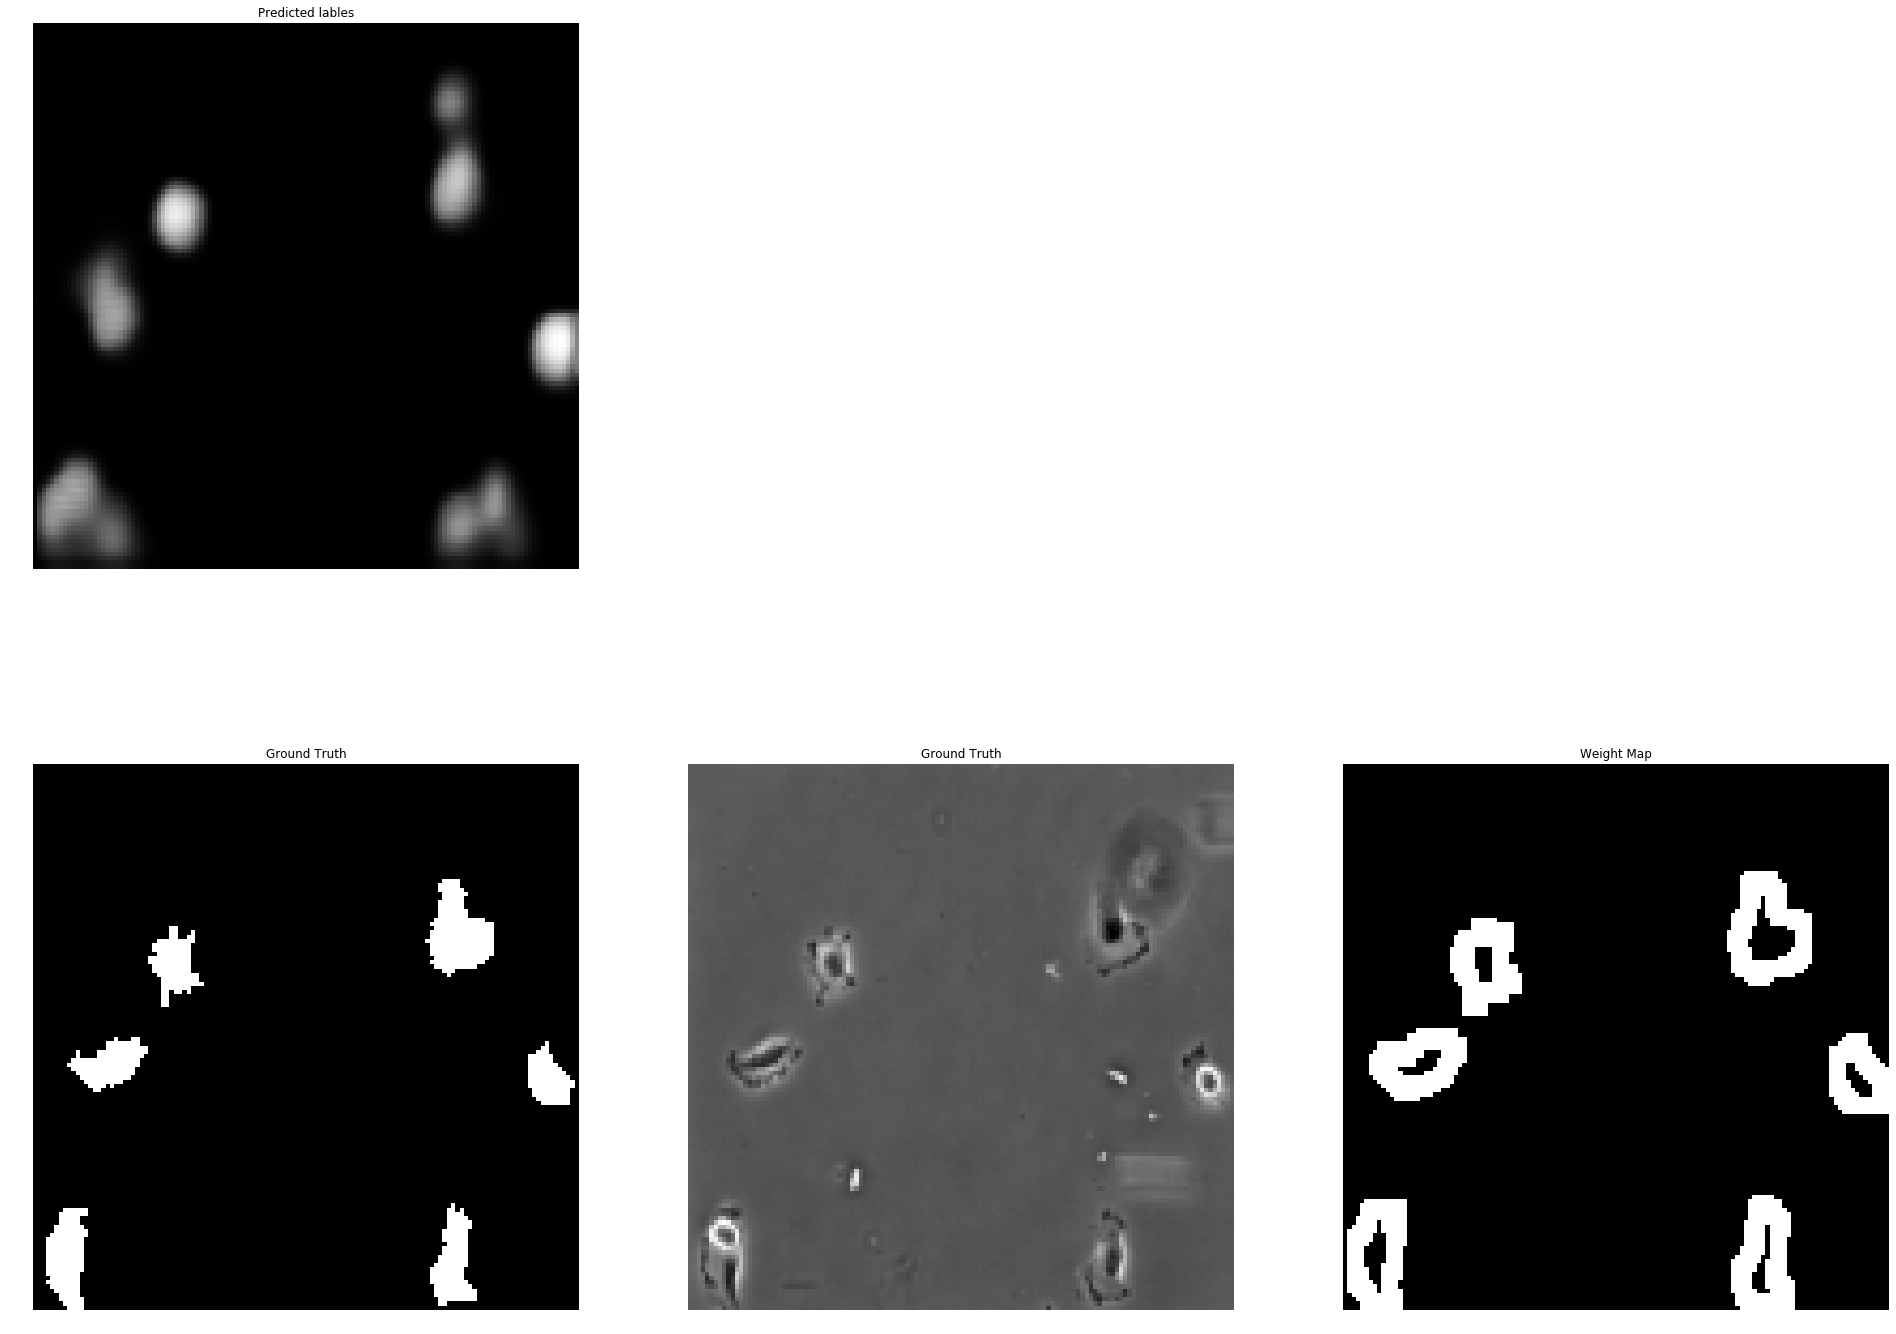

In [5]:
fig_acc = plt.figure(figsize=(45,25))

for i,prediction in enumerate(predictions):

    # add a polar subplot
    plt.subplot(2,4,i+1)
    plt.title("Predicted lables")
    #predictions[predictions>0.0000005]=1
    plt.imshow(prediction[15,:,:,0], cmap = "gray")
    #plt.colorbar()
    plt.axis('off')

plt.subplot(245)
plt.title("Ground Truth")
plt.imshow(train_mask[15,:,:,0], cmap = "gray")
#plt.colorbar()
plt.axis('off')


plt.subplot(246)
plt.title("Ground Truth")
plt.imshow(train_img[15,:,:,0], cmap = "gray")
#plt.colorbar
plt.axis('off')


plt.subplot(247)
plt.title("Weight Map")
plt.imshow(weight_maps[15,:,:,0], cmap = "gray")
plt.axis('off')
plt.show()

In [ ]:
#lstm without data augmentation
from Utils.u_net_LSTM import u_net_lstm
predictions =[]
models = ["FR-Fa-GE/FR-Fa-GE_weights_fold2_test0.h5"]

for modeli in models:
    if "Weigthed" in modeli:
        print("true")
        weights = True
    if "FR-Fa-GE" in modeli:
        weights = True
    else:
        print("false")
        weights = False
    
    if "LSTM" in modeli:
        if weights:
            model, input_weights = u_net_lstm(base, img_w, img_h, img_ch, batch_normalization, SDRate, spatial_dropout, final_neurons,"sigmoid",weights)
        else:
            model = u_net_lstm(base, img_w, img_h, img_ch, batch_normalization, SDRate, spatial_dropout, final_neurons,"sigmoid",weights)
       
    else:
        if weights:
            model, input_weights = u_net(base, img_w, img_h, img_ch, batch_normalization, SDRate, spatial_dropout, final_neurons,"sigmoid",weights)
        else:
            model = u_net(base, img_w, img_h, img_ch, batch_normalization, SDRate, spatial_dropout, final_neurons,"sigmoid",weights)
       
    # Load weights into the new model
    print("loading weigths")
    model.load_weights('Models/'+modeli)

    #Compile the model with weighted cross-entropy loss and metric as jaccard_distance
    model.compile(optimizer = Adam(lr=LR), loss = weighted_bce_loss(input_weights, weight_strength), metrics =[jaccard_loss])

    predictions.append(model.predict([train_img,weight_maps]))
    
